In [ ]:
import pandas as pd
from operator import itemgetter

# nltk is what does all the magic language parsing
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

# for parsing wonky HTML-tag-cluttered descriptions
import html2text
from lxml import html

import numpy as np
import re

# for making timing performance tests
import time


# for fetching book descriptions
import requests
from googlesearch import search

# for stop words
from spacy.lang.en import STOP_WORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

# On your first time running this program, you'll need to run the following line to download the stuff from nltk to your local machine
# nltk.download(['stopwords', 'wordnet'])

ModuleNotFoundError: No module named 'spacy'

In [2]:
#Long stop words list using 3 different python stopword libraries

stops = list(set(ENGLISH_STOP_WORDS)) + list(set(stopwords.words('english') +  list(set(STOP_WORDS)) + ["http"]))

In [3]:
#This Block loads the Lexicon and creates a data structure for the emotion intensity

fileEmotion = "emotion_itensity.txt"
table = pd.read_csv(fileEmotion,  names=["word", "emotion", "itensity"], sep='\t')

#create the dictionary with the word/emotion/score
emotion_dic = dict()
lmtzr = WordNetLemmatizer()
for index, row in table.iterrows():
    #add first as it is given in the lexicon
    temp_key = row['word'] + '#' + row['emotion']
    emotion_dic[temp_key] = row['itensity']

    #add in the normal noun form
    temp_key_n = lmtzr.lemmatize(row['word']) + '#' + row['emotion']
    emotion_dic[temp_key_n] = row['itensity']
    
    #add in the normal verb form
    temp_key_v = lmtzr.lemmatize(row['word'], 'v') + '#' + row['emotion']
    emotion_dic[temp_key_v] = row['itensity']    

In [4]:
#create h to clean descriptions in case they are in html format
h = html2text.HTML2Text()
h.ignore_links = True

In [5]:
#function that get the emotion itensity
def getEmotionItensity(word,emotion):
    key = word + "#" + emotion
    try:
        return emotion_dic[key]
    except:
        return 0.0

In [6]:
#Check if the word is in the Lexicon
def isWordInEmotionFile(word):
    # Slightly faster implementation
    for key in emotion_dic.keys():
        if key.startswith(word + "#"):
            return True
    return False
    
# print(isWordInEmotionFile("anger"), isWordInEmotionFile("help"), isWordInEmotionFile("booger"))

In [7]:
#Stopping checker 
def isStopWord(word):
    if word in stops:
        return True
    else:
        return False

In [8]:
#Assign the emotion itensity to the dictionary
def calculateEmotion(emotions, word):
    emotions["Anger"] += getEmotionItensity(word, "anger")
    emotions["Anticipation"] += getEmotionItensity(word, "anticipation")
    emotions["Disgust"] += getEmotionItensity(word, "disgust")
    emotions["Fear"] += getEmotionItensity(word, "fear")
    emotions["Joy"] += getEmotionItensity(word, "joy")
    emotions["Sadness"] += getEmotionItensity(word, "sadness")
    emotions["Surprise"] += getEmotionItensity(word, "surprise")
    emotions["Trust"] += getEmotionItensity(word, "trust")

In [9]:
#get the emotion vector of a given text
def getEmotionVector(text, removeObj = False, useSynset = True):
    #create the initial emotions
    emotions = {"Anger": 0.0,
                "Anticipation": 0.0,
                "Disgust": 0.0,
                "Fear": 0.0,
                "Joy": 0.0,
                "Sadness": 0.0,
                "Surprise": 0.0,
                "Trust": 0.0,
                "Objective": 0.0}
    #parse the description
    str = re.sub("[^a-zA-Z]+", " ", text) # replace all non-letters with a space
    pat = re.compile(r'[^a-zA-Z ]+')
    str = re.sub(pat, '', str).lower() #  convert to lowercase

    #split string
    splits = str.split()

    
    #iterate over words array
    for split in splits:
        if not isStopWord(split):
            #first check if the word appears as it does in the text
            if isWordInEmotionFile(split): 
                calculateEmotion(emotions, split)
                
            # check the word in noun form (bats -> bat)
            elif isWordInEmotionFile(lmtzr.lemmatize(split)):
                calculateEmotion(emotions, lmtzr.lemmatize(split))
                
            # check the word in verb form (ran/running -> run)
            elif isWordInEmotionFile(lmtzr.lemmatize(split, 'v')):
                calculateEmotion(emotions, lmtzr.lemmatize(split, 'v'))  
                
            # check synonyms of this word
            elif useSynset and wordnet.synsets(split) is not None:
                # only check the first two "senses" of a word, so we don't stray too far from its intended meaning
                for syn in wordnet.synsets(split)[0:1]:
                    for l in syn.lemmas():
                        if isWordInEmotionFile(l.name()):
                            calculateEmotion(emotions, l.name())
                            continue
                            
                # none of the synonyms matched something in the file
                emotions["Objective"] += 1
                
            else:
                # not found in the emotion file, assign a score to Objective instead
                emotions["Objective"] += 1

    # remove the Objective category if requested
    if removeObj:
        del emotions['Objective']
        
    total = sum(emotions.values())
    for key in sorted(emotions.keys()):
        try:
            # normalize the emotion vector
            emotions[key] = (1.0 / total) * emotions[key]
        except:
            emotions[key] = 0

    return emotions


In [10]:
# Fetch a book's description from Apple Books given its name
def fetchBookDesc(name):
    # find the url via google
    query = "site:books.apple.com " + name
    returnSearch = search(query, tld='com', lang='en', num=1, stop=3, pause=0.5)
    url = next(returnSearch)
    
    # need to pretend to be a user rather than a robot
    headers = {    'User-Agent': 'My User Agent 1.0',}
    page = requests.get(url, headers=headers)
    page.raise_for_status()

    # by knowing how apple books is laid out, we can find the div with the description
    tree = html.fromstring(page.content)
    frame = tree.xpath('//div[not(@class="we-lockup__title ")]/p[not(contains(text(),"\n"))]/text()')
    
    # convert frame to a string description
    return ' '.join(frame)
    
# fetchBookDesc("Harry Potter and the Chamber of Secrets")

In [11]:
#This block just test the functions above
#open description file
# file = open("description.txt","r")
# str_f = file.read()
# file.close()

# fetch book description from Apple Books
# str_f = fetchBookDesc("Stephen King's IT: novel")
# formatedDescription = h.handle(str_f)
# results = getEmotionVector(formatedDescription)

# print(results)

import matplotlib.pyplot as plt
from pylab import rcParams

# Graphs the emotion vector as a horizontal bar graph
def graphVector(results, title="Emotion Intensity", hasObjective = True):
    r = dict(results)
    if hasObjective:
        plt.barh(range(len(r)), list(r.values()), align='center')
        plt.yticks(range(len(r)), list(r.keys()))
    
        #plt.xlabel('Emotion')
        plt.title(title + ' with Objective')
        plt.show()
        
        del r['Objective']
        
    plt.barh(range(len(r)), list(r.values()), align='center')
    plt.yticks(range(len(r)), list(r.keys()))

    #plt.xlabel('Emotion')
    plt.title(title)
    plt.show()

# graphVector(results)

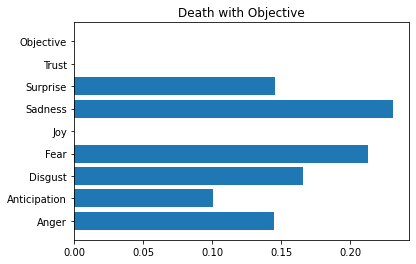

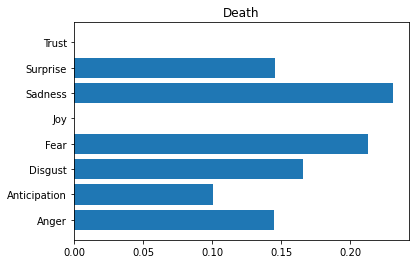

In [12]:
graphVector(getEmotionVector("death"), "Death")

In [42]:
# Generate a vector for every book in the csv file, then output those vectors to another file
# Only needs to be run once per file
# THIS WILL TAKE A WHILE
ratings_file = '../../../Data/Teenager_GoodReads.csv'
books = pd.read_csv(ratings_file)
# initialize the columns in the dataframe where our emotion vectors go
books["no_synset"] = "" * len(books.index)
books["synset"] = "" * len(books.index)

# add all the vectors to a csv file
sampleSize = 2000
startIndex = 3020

for index in range(startIndex, startIndex + sampleSize):
   
    d = books.loc[index, 'description']
    if d is None or type(d) is not str:
        continue
        
    description = h.handle(d)
#     print(index, description)
    
    books.loc[index, 'no_synset'] = str(getEmotionVector(description, useSynset = False))
    books.loc[index, 'synset'] = str(getEmotionVector(description))
#output file    
books.to_csv('ratings_teen_processed.csv')

In [17]:
def graphDictionary(dict, desc = ""):
    graphVector(dict["12-13"], "12-13" + desc)
    graphVector(dict["14-15"], "14-15" + desc)
    graphVector(dict["16-17"], "16-17" + desc)
    graphVector(dict["18+"], "18-19" + desc)

In [ ]:
import math

ratings_file = '../../../Data/Teenager_GoodReads.csv' # teenager review data
ratings = pd.read_csv(ratings_file)

rat_12 = ratings[ratings["age"] == 12]

ageRatings = {
    12: [],
    13: [],
    14: [],
    15: [],
    16: [],
    17: [],
    18: [],
    19: []
}
for age in range(12, 20):
    ageRatings[age] = ratings[(ratings["age"] >= age) & (ratings['age'] < age+1)]

# ageRatings[14].head()

In [ ]:
# create the graph representing the books rated between min and max rating, considering specified ages (list)
def makeGraphs(ages, minRating=0, maxRating=5):
    print(ages,minRating,maxRating)
    avgVector = getEmotionVector("")

    for age in ages:
        print("Parsing data for ", age, " year-olds")
        data = ageRatings[age]
        filtered = data[(data["avg_rating"] >= minRating) & (data["avg_rating"] <= maxRating)]
        
        limit = 100 # only select a sample of this many
        currIter = 0
        for index, row in filtered.iterrows():
            if currIter >= limit:
                break
            currIter += 1

            
            d = row["description"]
            if d is None or type(d) is not str:
                continue

            # description exists
            description = h.handle(d)
            v = getEmotionVector(description)
            for key in avgVector:
                avgVector[key] += v[key]
    
    return avgVector

In [ ]:
def noObj(v):
    r = dict(v)
    del r["Objective"]
    return r

In [ ]:
def graphDifference(a, b, title = "difference"):
    # graph the difference between two emotion vectors
    dif = b - a
    emotions = {"Anger": dif[0],
            "Anticipation": dif[1],
            "Disgust": dif[2],
            "Fear": dif[3],
            "Joy": dif[4],
            "Sadness": dif[5],
            "Surprise": dif[6],
            "Trust": dif[7]}
    if len(dif) > 8:
        emotions["Objective"] = dif[8]
    # visually show the difference
    graphVector(emotions, title, False)
    return dif

In [ ]:
def vectorMatch(zero, compare, shouldGraph = True, title = "difference"):
    # compare how close 'zero' and 'compare' are to each other visually
#     graphVector(zero, 'samp', False)
#     graphVector(compare, 'comp', False)
    # convert to np arrays
    zero = np.array(list(zero.values()))
    compare = np.array(list(compare.values()))
    
    # normalize both vectors
    zero = zero / np.linalg.norm(zero)
    compare = compare / np.linalg.norm(compare)
    
    # graph the difference graph
    if shouldGraph:
        graphDifference(zero, compare, title)
    
    # return the magnitude of the vector of the difference
    return np.linalg.norm(compare - zero)

# experiment shows that objective should largely be ignored


In [19]:
# DICTIONARY STRINGS
# See Also: Appendix II of our paper, located at the root of this github repo

# without synset
veryGood = {'12-13': {'Anger': 0.02607737447252457, 'Anticipation': 0.05591565890156308, 'Disgust': 0.016045564608362352, 'Fear': 0.04789091036691487, 'Joy': 0.07800394549107047, 'Sadness': 0.02963231050132504, 'Surprise': 0.025570341420305114, 'Trust': 0.07646456858162831, 'Objective': 0.6443993256563062}, '14-15': {'Anger': 0.03133700242969171, 'Anticipation': 0.05306542575331012, 'Disgust': 0.02052466230415404, 'Fear': 0.050078575418488806, 'Joy': 0.07091271631929497, 'Sadness': 0.036037637580607344, 'Surprise': 0.024350939438084956, 'Trust': 0.07197318113344676, 'Objective': 0.6417198596229213}, '16-17': {'Anger': 0.0333773979974969, 'Anticipation': 0.05330467754243581, 'Disgust': 0.02097467965804083, 'Fear': 0.05641121602721728, 'Joy': 0.0717972294372776, 'Sadness': 0.04119477515402107, 'Surprise': 0.02393239572109254, 'Trust': 0.07262647668304764, 'Objective': 0.6263811517793704}, '18+': {'Anger': 0.027350619283685446, 'Anticipation': 0.04834423625870798, 'Disgust': 0.01810802229683925, 'Fear': 0.04711267423376138, 'Joy': 0.0682425285607569, 'Sadness': 0.03469139079167855, 'Surprise': 0.024225540160949112, 'Trust': 0.07372016783601339, 'Objective': 0.658204820577608}}
medium = {'12-13': {'Anger': 0.029189140945891232, 'Anticipation': 0.051557508020711164, 'Disgust': 0.016899369038538357, 'Fear': 0.04755995823626276, 'Joy': 0.06660662293889227, 'Sadness': 0.03507920186496511, 'Surprise': 0.028374183831625363, 'Trust': 0.07083812291298776, 'Objective': 0.6538958922101261}, '14-15': {'Anger': 0.0285833109659729, 'Anticipation': 0.057618467957265156, 'Disgust': 0.01961486079752071, 'Fear': 0.052700259717779016, 'Joy': 0.07232740308860498, 'Sadness': 0.03513043731590352, 'Surprise': 0.02588909747908478, 'Trust': 0.07539679181497354, 'Objective': 0.6327393708628954}, '16-17': {'Anger': 0.025644625944838434, 'Anticipation': 0.051360156037244954, 'Disgust': 0.017925369540969096, 'Fear': 0.04640777241724535, 'Joy': 0.060824867086734236, 'Sadness': 0.03225630922943315, 'Surprise': 0.026661435749587997, 'Trust': 0.06426302689204114, 'Objective': 0.6746564371019056}, '18+': {'Anger': 0.02526227585581172, 'Anticipation': 0.04694168121197902, 'Disgust': 0.018564253736720836, 'Fear': 0.04646442057241248, 'Joy': 0.0634355612618883, 'Sadness': 0.03280124674603629, 'Surprise': 0.024291726419989793, 'Trust': 0.07112877986963899, 'Objective': 0.6711100543255224}}
bad = {'12-13': {'Anger': 0.014256266830366897, 'Anticipation': 0.049176530976752016, 'Disgust': 0.007874240160354389, 'Fear': 0.025594917066862136, 'Joy': 0.06747528283150003, 'Sadness': 0.016159672424431983, 'Surprise': 0.02917186766565966, 'Trust': 0.07731285216349064, 'Objective': 0.7129783698805822}, '14-15': {'Anger': 0.014115226149470509, 'Anticipation': 0.04034092911328387, 'Disgust': 0.010038021527596707, 'Fear': 0.029141883181940137, 'Joy': 0.058447614793800576, 'Sadness': 0.01528371769742746, 'Surprise': 0.014531136480208482, 'Trust': 0.09533626642161397, 'Objective': 0.7227652046346582}, '16-17': {'Anger': 0.018530938051548828, 'Anticipation': 0.04952214921103868, 'Disgust': 0.010244400746641341, 'Fear': 0.03049261738092707, 'Joy': 0.06100403145970391, 'Sadness': 0.023510096408279352, 'Surprise': 0.017283416843489417, 'Trust': 0.0778980982594321, 'Objective': 0.7115142516389393}, '18+': {'Anger': 0.018685170909377744, 'Anticipation': 0.04940155601721161, 'Disgust': 0.016405495432130657, 'Fear': 0.035722493931139354, 'Joy': 0.06305838192496861, 'Sadness': 0.022540359501121345, 'Surprise': 0.016742206897730393, 'Trust': 0.07503267563743672, 'Objective': 0.7024116597488834}}

# with synset
# veryGood = {'12-13': {'Anger': 0.03324516731797181, 'Anticipation': 0.06316521380213953, 'Disgust': 0.022227091137027172, 'Fear': 0.05691485227312035, 'Joy': 0.08137360321373614, 'Sadness': 0.03561005495603787, 'Surprise': 0.02753410719569374, 'Trust': 0.08740544859699105, 'Objective': 0.5925244615072824}, '14-15': {'Anger': 0.03845659187984517, 'Anticipation': 0.05968186928716008, 'Disgust': 0.024811851649648775, 'Fear': 0.060174546666221615, 'Joy': 0.07738135360361288, 'Sadness': 0.041013853384338446, 'Surprise': 0.026242366975899992, 'Trust': 0.08078540253353338, 'Objective': 0.5914521640197395}, '16-17': {'Anger': 0.03937934022078974, 'Anticipation': 0.06168553740119403, 'Disgust': 0.02437694812017651, 'Fear': 0.06467916627690419, 'Joy': 0.07596938986336625, 'Sadness': 0.04700959580673139, 'Surprise': 0.02631626776151658, 'Trust': 0.08092024537924439, 'Objective': 0.579663509170077}, '18+': {'Anger': 0.032588571818511436, 'Anticipation': 0.056495245508095024, 'Disgust': 0.021237897122595596, 'Fear': 0.054496669724892546, 'Joy': 0.07277402651940436, 'Sadness': 0.039143449052118896, 'Surprise': 0.025819972212946407, 'Trust': 0.08610576994731546, 'Objective': 0.6113383980941202}} 
# medium = {'12-13': {'Anger': 0.03374098128626937, 'Anticipation': 0.06018846633940684, 'Disgust': 0.019014375576554318, 'Fear': 0.054401185770716745, 'Joy': 0.07337335029206232, 'Sadness': 0.04040692892957006, 'Surprise': 0.030654045663137744, 'Trust': 0.08191808222017224, 'Objective': 0.6063025839221104}, '14-15': {'Anger': 0.03359076268594646, 'Anticipation': 0.06787135639254616, 'Disgust': 0.023418184759612503, 'Fear': 0.06048732307267755, 'Joy': 0.07937567941882766, 'Sadness': 0.04013902205286797, 'Surprise': 0.02947897436360671, 'Trust': 0.08800879300797261, 'Objective': 0.5776299042459424}, '16-17': {'Anger': 0.030456968279124176, 'Anticipation': 0.059058054919972264, 'Disgust': 0.02198290389875575, 'Fear': 0.05303760271253788, 'Joy': 0.0657024268770311, 'Sadness': 0.036185701108150475, 'Surprise': 0.029020076627564884, 'Trust': 0.0760225808088485, 'Objective': 0.628533684768015}, '18+': {'Anger': 0.031729533860877006, 'Anticipation': 0.05606660712348232, 'Disgust': 0.022249649499262326, 'Fear': 0.05366896026485633, 'Joy': 0.06871372152832912, 'Sadness': 0.036852106253912366, 'Surprise': 0.025940952655220298, 'Trust': 0.08186879744428478, 'Objective': 0.6229096713697754}} 
# bad = {'12-13': {'Anger': 0.017655532155044198, 'Anticipation': 0.05744157750390466, 'Disgust': 0.008167936076363206, 'Fear': 0.030417773390982866, 'Joy': 0.07423649832532445, 'Sadness': 0.017440343259113648, 'Surprise': 0.02993467844844481, 'Trust': 0.08817932713834818, 'Objective': 0.676526333702474}, '14-15': {'Anger': 0.02020149395761844, 'Anticipation': 0.047565525231736176, 'Disgust': 0.014517292449512638, 'Fear': 0.03547664051539909, 'Joy': 0.06533833356520834, 'Sadness': 0.021882118715121295, 'Surprise': 0.017664024997972833, 'Trust': 0.1132199386684898, 'Objective': 0.6641346318989414}, '16-17': {'Anger': 0.023330231392691952, 'Anticipation': 0.05884361939206312, 'Disgust': 0.014104841767633436, 'Fear': 0.037962854154754415, 'Joy': 0.06730466563882047, 'Sadness': 0.02811541783833771, 'Surprise': 0.018701038338162976, 'Trust': 0.0913024999787434, 'Objective': 0.6603348314987926}, '18+': {'Anger': 0.02356251104255825, 'Anticipation': 0.05656267181417433, 'Disgust': 0.019254852068808205, 'Fear': 0.042011270869920375, 'Joy': 0.07456356532678587, 'Sadness': 0.0259438858942028, 'Surprise': 0.018840096630702702, 'Trust': 0.08805987687649008, 'Objective': 0.6512012694763574}}

